# Graph Kernels

This notebook demonstrates how regression models can be constructed on the vertices of a graph using a Gaussian process with a Matérn kernel presented in  <strong data-cite="borovitskiy2021matern"></strong>. For a general discussion of the kernels supported within GPJax, see the [kernels notebook](https://gpjax.readthedocs.io/en/latest/nbs/kernels.html).

In [1]:
import random

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import networkx as nx
import optax as ox
from jax import jit
from jax.config import config
from jaxutils import Dataset
import jaxkern as jk

import gpjax as gpx

# Enable Float64 for more stable matrix inversions.
config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)

## Graph construction

Our graph $\mathcal{G}=\lbrace V, E \rbrace$ comprises a set of vertices $V = \lbrace v_1, v_2, \ldots, v_n\rbrace$ and edges $E=\lbrace (v_i, v_j)\in V \ : \ i \neq j\rbrace$. In particular, we will consider a [barbell graph](https://en.wikipedia.org/wiki/Barbell_graph) that is an undirected graph containing two clusters of vertices with a single shared edge between the two clusters.

Contrary to the typical barbell graph, we'll randomly remove a subset of 30 edges within each of the two clusters. Given the 40 vertices within the graph, this results in 351 edges as shown below.

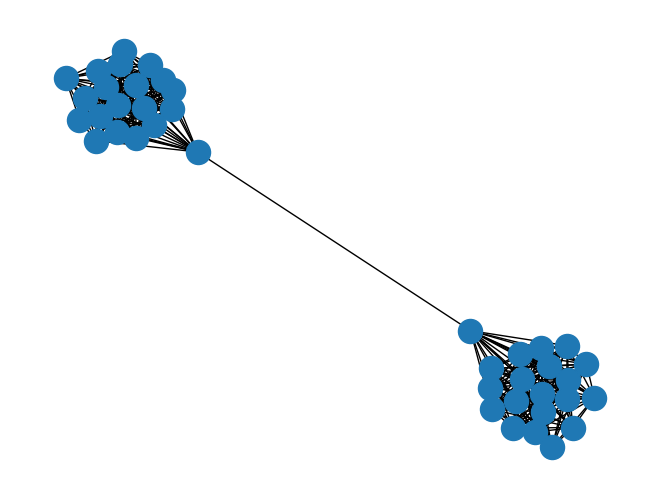

In [2]:
vertex_per_side = 20
n_edges_to_remove = 30
p = 0.8

G = nx.barbell_graph(vertex_per_side, 0)

random.seed(123)
[G.remove_edge(*i) for i in random.sample(list(G.edges), n_edges_to_remove)]

pos = nx.spring_layout(G, seed=123)  # positions for all nodes

nx.draw(G)  # , pos, node_color="tab:blue", with_labels=False, alpha=0.5)


### Computing the graph Laplacian

Graph kernels use the _Laplacian matrix_ $L$ to quantify the smoothness of a signal (or function) on a graph
$$L=D-A,$$
where $D$ is the diagonal _degree matrix_ containing each vertices' degree and $A$ is the _adjacency matrix_ that has an $(i,j)^{\text{th}}$ entry of 1 if $v_i, v_j$ are connected and 0 otherwise. [Networkx](https://networkx.org) gives us an easy way to compute this.

In [3]:
L = nx.laplacian_matrix(G).toarray()


## Simulating a signal on the graph

Our task is to construct a Gaussian process $f(\cdot)$ that maps from the graph's vertex set $V$ onto the real line.
To that end, we begin by simulating a signal on the graph's vertices that we will go on to try and predict.
We use a single draw from a Gaussian process prior to draw our response values $\boldsymbol{y}$ where we hardcode parameter values.
The corresponding input value set for this model, denoted $\boldsymbol{x}$, is the index set of the graph's vertices.

In [4]:
x = jnp.arange(G.number_of_nodes()).reshape(-1, 1)

kernel = jk.GraphKernel(laplacian=L)
prior = gpx.Prior(kernel=kernel)

true_params = prior.init_params(key)
true_params["kernel"] = {
    "lengthscale": jnp.array(2.3),
    "variance": jnp.array(3.2),
    "smoothness": jnp.array(6.1),
}

fx = prior(true_params)(x)
y = fx.sample(seed=key).reshape(-1, 1)

D = Dataset(X=x, y=y)

In [5]:
kernel.compute_engine.gram

<function jaxkern.kernels.AbstractKernelComputation.gram(self, params: Dict, inputs: jaxtyping.Float[Array, 'N D']) -> jaxlinop.linear_operator.LinearOperator>

In [6]:
kernel.gram(params=kernel.init_params(key), inputs=x)


We can visualise this signal in the following cell.

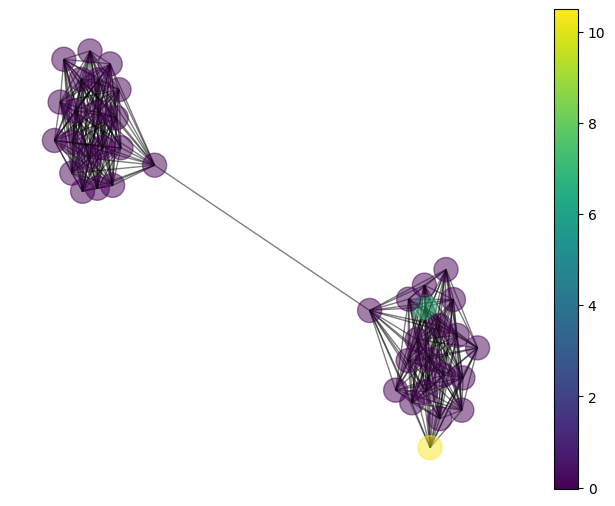

In [7]:
nx.draw(G, pos, node_color=y, with_labels=False, alpha=0.5)

vmin, vmax = y.min(), y.max()
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.viridis, norm=plt.Normalize(vmin=vmin, vmax=vmax)
)
sm.set_array([])
cbar = plt.colorbar(sm)


## Constructing a graph Gaussian process

With our dataset created, we proceed to define our posterior Gaussian process and optimise the model's hyperparameters.
Whilst our underlying space is the graph's vertex set and is therefore non-Euclidean, our likelihood is still Gaussian and the model is still conjugate.
For this reason, we simply perform gradient descent on the GP's marginal log-likelihood term as in the [regression notebook](https://gpjax.readthedocs.io/en/latest/nbs/regression.html). We do this using the Adam optimiser provided in `optax`.

In [8]:
likelihood = gpx.Gaussian(num_datapoints=y.shape[0])
posterior = prior * likelihood

parameter_state = gpx.initialise(posterior, key)
negative_mll = jit(posterior.marginal_log_likelihood(train_data=D, negative=True))
optimiser = ox.adam(learning_rate=0.01)

inference_state = gpx.fit(
    objective=negative_mll,
    parameter_state=parameter_state,
    optax_optim=optimiser,
    num_iters=1000,
)

learned_params, training_history = inference_state.unpack()

  0%|          | 0/1000 [00:00<?, ?it/s]


## Making predictions

Having optimised our hyperparameters, we can now make predictions on the graph.
Though we haven't defined a training and testing dataset here, we'll simply query the predictive posterior for the full graph to compare the root-mean-squared error (RMSE) of the model for the initialised parameters vs the optimised set.

In [9]:
initial_params = parameter_state.params
initial_dist = likelihood(initial_params, posterior(initial_params, D)(x))
predictive_dist = likelihood(learned_params, posterior(learned_params, D)(x))

initial_mean = initial_dist.mean()
learned_mean = predictive_dist.mean()

rmse = lambda ytrue, ypred: jnp.sum(jnp.sqrt(jnp.square(ytrue - ypred)))

initial_rmse = jnp.sum(jnp.sqrt(jnp.square(y.squeeze() - initial_mean)))
learned_rmse = jnp.sum(jnp.sqrt(jnp.square(y.squeeze() - learned_mean)))
print(
    f"RMSE with initial parameters: {initial_rmse: .2f}\nRMSE with learned parameters:"
    f" {learned_rmse: .2f}"
)

RMSE with initial parameters:  2.40
RMSE with learned parameters:  0.21



We can also plot the source of error in our model's predictions on the graph by the following.

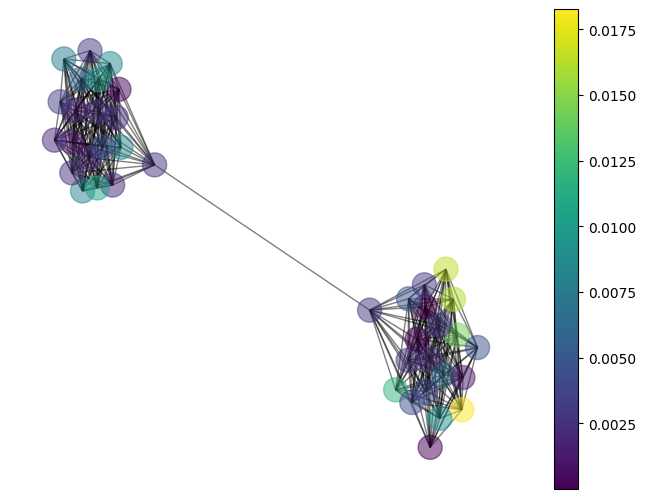

In [10]:
error = jnp.abs(learned_mean - y.squeeze())

nx.draw(G, pos, node_color=error, with_labels=False, alpha=0.5)

vmin, vmax = error.min(), error.max()
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.viridis, norm=plt.Normalize(vmin=vmin, vmax=vmax)
)
sm.set_array([])
cbar = plt.colorbar(sm)


Reassuringly, our model seems to provide equally good predictions in each cluster.

## System configuration

In [11]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Thomas Pinder (edited by Daniel Dodd)'

Author: Thomas Pinder (edited by Daniel Dodd)

Last updated: Sat Jan 14 2023

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.8.0

matplotlib: 3.3.3
gpjax     : 0.5.8
jax       : 0.4.1
networkx  : 2.6.3
optax     : 0.1.4
jaxkern   : 0.0.4

Watermark: 2.3.1

